# Klasifikasi Penyakit Hati (UAS)

Dataset ini dibuat untuk mengetahui apakah pasien di india mengalami penyakit hati berdasarkan informasi tentang beberapa penanda biokimia, termasuk albumin dan enzim lain yang diperlukan untuk metabolisme.

## Data Understanding

In [ ]:
pip install ucimlrepo

### Visualisasi Data

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
ilpd_indian_liver_patient_dataset = fetch_ucirepo(id=225)

# data (as pandas dataframes)
X = ilpd_indian_liver_patient_dataset.data.features
y = ilpd_indian_liver_patient_dataset.data.targets

# metadata
print(ilpd_indian_liver_patient_dataset.metadata)

# variable information
print(ilpd_indian_liver_patient_dataset.variables)


{'uci_id': 225, 'name': 'ILPD (Indian Liver Patient Dataset)', 'repository_url': 'https://archive.ics.uci.edu/dataset/225/ilpd+indian+liver+patient+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/225/data.csv', 'abstract': 'Death by liver cirrhosis continues to increase, given the increase in alcohol consumption rates, chronic hepatitis infections, and obesity-related liver disease. Notwithstanding the high mortality of this disease, liver diseases do not affect all sub-populations equally. The early detection of pathology is a determinant of patient outcomes, yet female patients appear to be marginalized when it comes to early diagnosis of liver pathology. \nThe dataset comprises 584 patient records collected from the NorthEast of Andhra Pradesh, India.\nThe prediction task is to determine whether a patient suffers from liver disease based on the information about several biochemical markers, including albumin and other enzymes required for metabolism.\n', 'area': 'He

In [ ]:
print(X.head(10))
print(X.columns)
print(y.head(10))
print(y.columns)

   Age  Gender    TB   DB  Alkphos  Sgpt  Sgot   TP  ALB  A/G Ratio
0   65  Female   0.7  0.1      187    16    18  6.8  3.3       0.90
1   62    Male  10.9  5.5      699    64   100  7.5  3.2       0.74
2   62    Male   7.3  4.1      490    60    68  7.0  3.3       0.89
3   58    Male   1.0  0.4      182    14    20  6.8  3.4       1.00
4   72    Male   3.9  2.0      195    27    59  7.3  2.4       0.40
5   46    Male   1.8  0.7      208    19    14  7.6  4.4       1.30
6   26  Female   0.9  0.2      154    16    12  7.0  3.5       1.00
7   29  Female   0.9  0.3      202    14    11  6.7  3.6       1.10
8   17    Male   0.9  0.3      202    22    19  7.4  4.1       1.20
9   55    Male   0.7  0.2      290    53    58  6.8  3.4       1.00
Index(['Age', 'Gender', 'TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot', 'TP', 'ALB',
       'A/G Ratio'],
      dtype='object')
   Selector
0         1
1         1
2         1
3         1
4         1
5         1
6         1
7         1
8         2
9         1
I

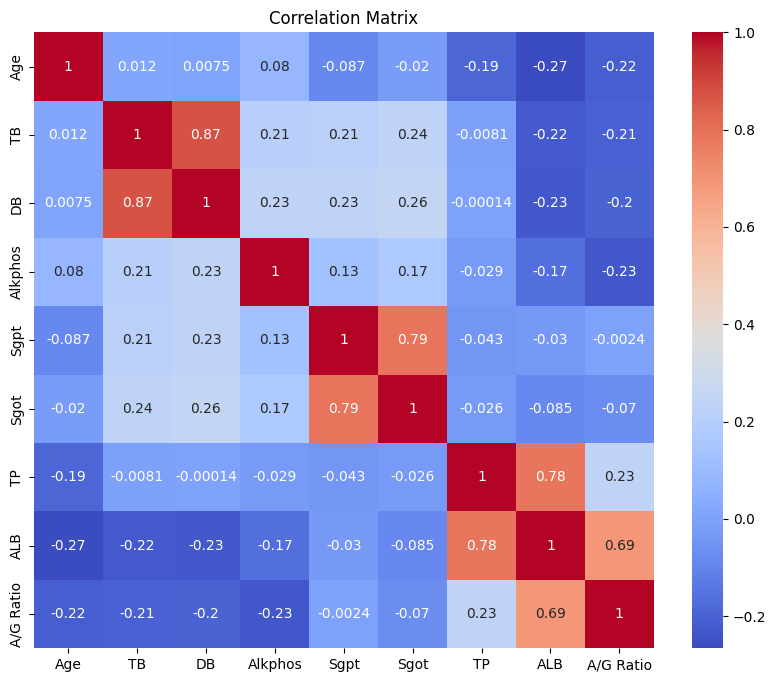

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [ ]:
import pandas as pd

# Hanya untuk fitur numerik
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
outlier_indices = {}

for col in numeric_cols:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = X[(X[col] < lower) | (X[col] > upper)].index
    outlier_indices[col] = outliers

    print(f"{col}: {len(outliers)} outliers")


Age: 0 outliers
TB: 84 outliers
DB: 81 outliers
Alkphos: 69 outliers
Sgpt: 73 outliers
Sgot: 66 outliers
TP: 8 outliers
ALB: 0 outliers
A/G Ratio: 10 outliers


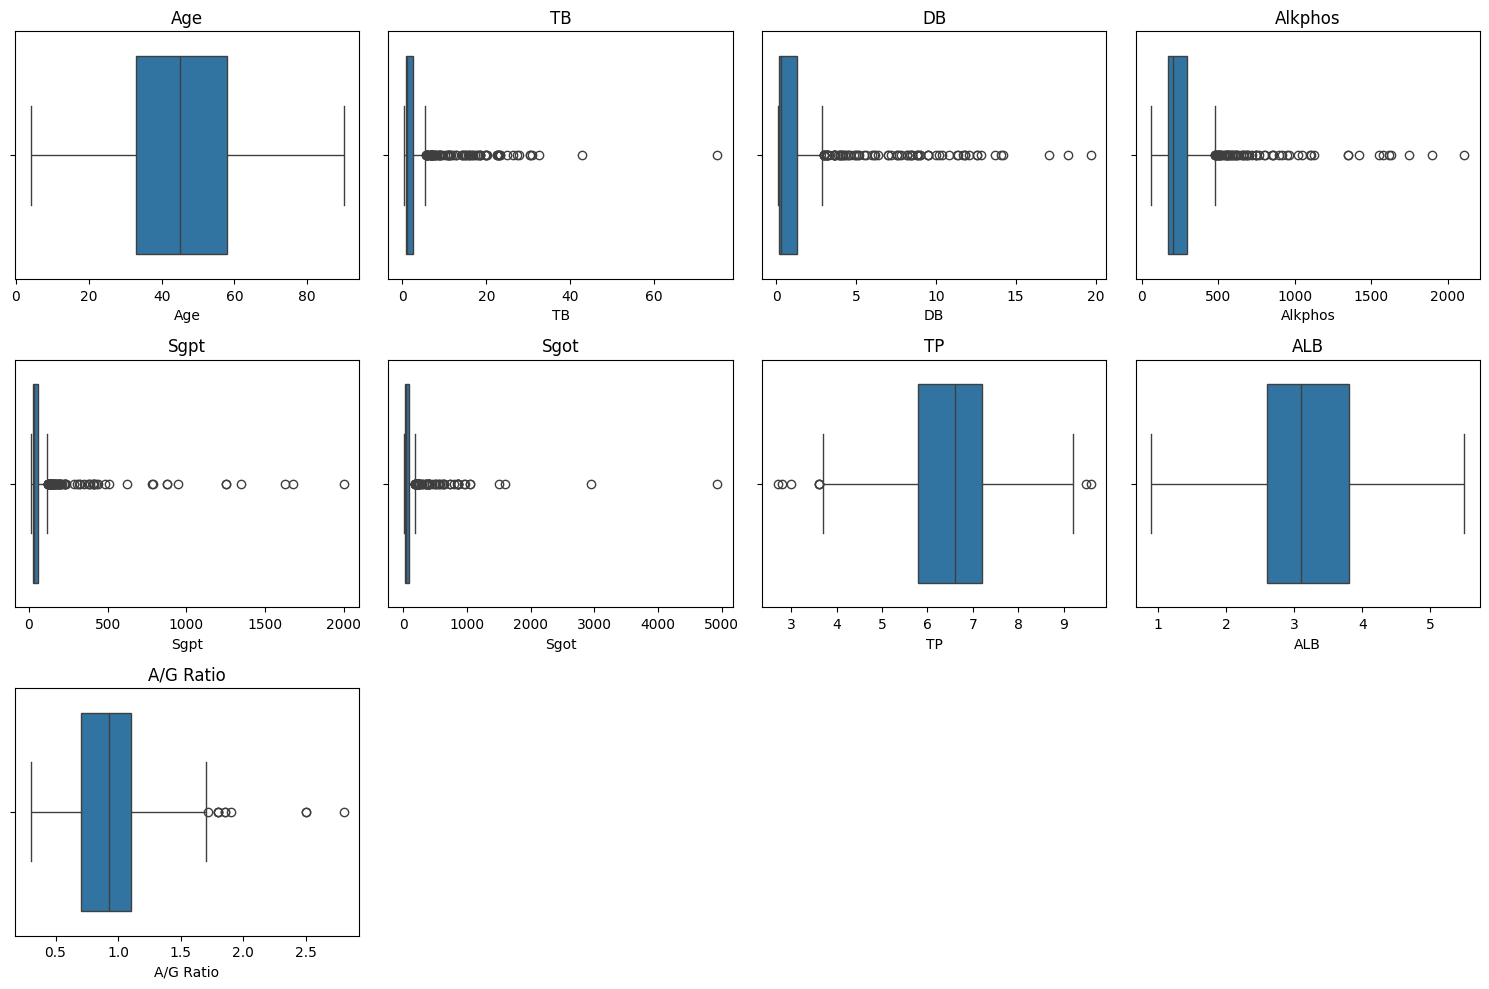

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x=X[col])
    plt.title(col)
plt.tight_layout()
plt.show()


## Preprocessing

Sebelum kita lakukan modelling, kita bersihkan outlier terlebih dahulu dengan metode deteksi LOF dan outlier di perbaiki dengan mean non outlier

### Membersihkan Outlier

In [ ]:
import numpy as np

X_clean = X.copy()
numeric_cols = X_clean.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    Q1 = X_clean[col].quantile(0.25)
    Q3 = X_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Dapatkan rata-rata data yang normal (tidak outlier)
    non_outliers = X_clean[(X_clean[col] >= lower) & (X_clean[col] <= upper)][col]
    mean_normal = non_outliers.mean()

    # Gantikan nilai outlier dengan rata-rata non-outlier
    X_clean[col] = X_clean[col].apply(
        lambda x: mean_normal if x < lower or x > upper else x
    )

X_clean= pd.DataFrame(X_clean)


print(X_clean.head(10))



   Age  Gender        TB        DB     Alkphos  Sgpt   Sgot   TP  ALB  \
0   65  Female  0.700000  0.100000  187.000000  16.0   18.0  6.8  3.3   
1   62    Male  1.352705  0.545618  220.317121  64.0  100.0  7.5  3.2   
2   62    Male  1.352705  0.545618  220.317121  60.0   68.0  7.0  3.3   
3   58    Male  1.000000  0.400000  182.000000  14.0   20.0  6.8  3.4   
4   72    Male  3.900000  2.000000  195.000000  27.0   59.0  7.3  2.4   
5   46    Male  1.800000  0.700000  208.000000  19.0   14.0  7.6  4.4   
6   26  Female  0.900000  0.200000  154.000000  16.0   12.0  7.0  3.5   
7   29  Female  0.900000  0.300000  202.000000  14.0   11.0  6.7  3.6   
8   17    Male  0.900000  0.300000  202.000000  22.0   19.0  7.4  4.1   
9   55    Male  0.700000  0.200000  290.000000  53.0   58.0  6.8  3.4   

   A/G Ratio  
0       0.90  
1       0.74  
2       0.89  
3       1.00  
4       0.40  
5       1.30  
6       1.00  
7       1.10  
8       1.20  
9       1.00  


Setelah menghilangkan outlier, kita encode kategorikal ke angka

### Encoding Gender ke Angka

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

X_c_encoded = X_clean.copy(deep=True)
# Pastikan semua kolom numerik secara eksplisit
X_c_encoded = X_c_encoded.apply(pd.to_numeric, errors='coerce')

# Encode variabel kategorik 'Gender'
le = LabelEncoder()
X_c_encoded['Gender'] = le.fit_transform(X_c_encoded['Gender'])

# Cek hasil encoding
print("Gender classes:", le.classes_)
print("Gender encoded values:", X_c_encoded['Gender'].unique())

# Tangani nilai NaN, misalnya dengan imputasi median
print("Jumlah NaN sebelum imputasi:", X_c_encoded.isna().sum().sum())
X_c_encoded = X_c_encoded.fillna(X_c_encoded.median())
print("Jumlah NaN setelah imputasi:", X_c_encoded.isna().sum().sum())


Gender classes: [nan]
Gender encoded values: [0]
Jumlah NaN sebelum imputasi: 4
Jumlah NaN setelah imputasi: 0


In [ ]:
print(X_clean.head(10))
print(X_clean.columns)
print(X_clean.dtypes)
print(X_clean.shape)



   Age  Gender        TB        DB     Alkphos  Sgpt   Sgot   TP  ALB  \
0   65  Female  0.700000  0.100000  187.000000  16.0   18.0  6.8  3.3   
1   62    Male  1.352705  0.545618  220.317121  64.0  100.0  7.5  3.2   
2   62    Male  1.352705  0.545618  220.317121  60.0   68.0  7.0  3.3   
3   58    Male  1.000000  0.400000  182.000000  14.0   20.0  6.8  3.4   
4   72    Male  3.900000  2.000000  195.000000  27.0   59.0  7.3  2.4   
5   46    Male  1.800000  0.700000  208.000000  19.0   14.0  7.6  4.4   
6   26  Female  0.900000  0.200000  154.000000  16.0   12.0  7.0  3.5   
7   29  Female  0.900000  0.300000  202.000000  14.0   11.0  6.7  3.6   
8   17    Male  0.900000  0.300000  202.000000  22.0   19.0  7.4  4.1   
9   55    Male  0.700000  0.200000  290.000000  53.0   58.0  6.8  3.4   

   A/G Ratio  
0       0.90  
1       0.74  
2       0.89  
3       1.00  
4       0.40  
5       1.30  
6       1.00  
7       1.10  
8       1.20  
9       1.00  
Index(['Age', 'Gender', 'TB', '

## Modelling

### KNN Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Split data terlebih dahulu
X_train, X_test, y_train, y_test = train_test_split(X_c_encoded, y, test_size=0.2, random_state=42)

# Lakukan scaling setelah split untuk menghindari data leakage
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Inisialisasi model KNN
knn = KNeighborsClassifier(n_neighbors=5)

# Training
knn.fit(X_train, y_train)

# Prediksi
y_pred = knn.predict(X_test)

# Evaluasi
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

           1       0.77      0.78      0.78        87
           2       0.34      0.33      0.34        30

    accuracy                           0.67       117
   macro avg       0.56      0.56      0.56       117
weighted avg       0.66      0.67      0.66       117



/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Pisahkan fitur dan target
X = X_c_encoded
y = y.values.ravel()  # pastikan target 1D

# Split data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inisialisasi dan latih model Decision Tree
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)

# Prediksi
y_pred = dtree.predict(X_test)

# Evaluasi
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.6581196581196581
              precision    recall  f1-score   support

           1       0.82      0.69      0.75        87
           2       0.39      0.57      0.46        30

    accuracy                           0.66       117
   macro avg       0.60      0.63      0.60       117
weighted avg       0.71      0.66      0.68       117



### Naive Bayes

Naive Bayes adalah algoritma klasifikasi berbasis probabilitas yang menggunakan Teorema Bayes, dengan asumsi "naif" bahwa setiap fitur bekerja secara independen terhadap fitur lainnya.

dalam Modelling kali ini, saya membuat dua model yang nanti di gabungkan untuk melakukan klasifikasi. ini lebih akurat dibanding memproses data ke numerik lalu melakukan modelling dengan gaussian naive bayes saja

In [ ]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Pisahkan fitur numerik dan kategorikal secara eksplisit
X_num = X_c_encoded.drop(columns=['Gender'])
X_cat = X_c_encoded[['Gender']]  # pastikan ini hanya kategorikal

# Split data
X_num_train, X_num_test, y_train, y_test = train_test_split(X_num, y, test_size=0.2, random_state=42)
X_cat_train, X_cat_test = train_test_split(X_cat, test_size=0.2, random_state=42)

# Pastikan target adalah array 1D
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# Tangani NaN di data numerik sebelum scaling
X_num_train = X_num_train.fillna(X_num_train.median())
X_num_test = X_num_test.fillna(X_num_train.median())

# Scaling numerik
scaler = StandardScaler()
X_num_train = scaler.fit_transform(X_num_train)
X_num_test = scaler.transform(X_num_test)

# Model GaussianNB
gnb = GaussianNB()
gnb.fit(X_num_train, y_train)

# Model CategoricalNB
cnb = CategoricalNB()
cnb.fit(X_cat_train, y_train)

# Log-probabilitas
log_prob_gnb = gnb.predict_log_proba(X_num_test)
log_prob_cnb = cnb.predict_log_proba(X_cat_test)

# Gabungan prediksi log-proba
combined_log_prob = log_prob_gnb + log_prob_cnb
y_pred = gnb.classes_[np.argmax(combined_log_prob, axis=1)]

# Evaluasi
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7435897435897436
              precision    recall  f1-score   support

           1       0.89      0.75      0.81        87
           2       0.50      0.73      0.59        30

    accuracy                           0.74       117
   macro avg       0.70      0.74      0.70       117
weighted avg       0.79      0.74      0.76       117



## Deploy

Dari Semua Model klasifikasi di atas, Naive Bayes Classifier Ensemble(Gabungan) memiliki skor akurasi paling tinggi. oleh karena itu, Model klasifikasi yang saya pakai adalah Naive Bayes Ensemble, berikut adalah kode untuk melihat bagaimana model digunakan

In [ ]:
# Ambil 10 data awal sebagai data testing
X_test_deploy = X_c_encoded.iloc[:10].copy()
X_num_deploy = X_test_deploy.drop(columns=['Gender'])
X_cat_deploy = X_test_deploy[['Gender']]

# Gunakan median dari data numerik training sebelum scaling
X_num_median = X_num.median()  # ← simpan ini sebelum split/scaling

# Imputasi NaN pada data deploy
X_num_deploy = X_num_deploy.fillna(X_num_median)

# Scaling dengan scaler yang dilatih dari training
X_num_deploy = scaler.transform(X_num_deploy)

# Prediksi log-proba
log_prob_deploy_gnb = gnb.predict_log_proba(X_num_deploy)
log_prob_deploy_cnb = cnb.predict_log_proba(X_cat_deploy)

# Gabungkan log-probabilitas dan prediksi akhir
combined_log_prob_deploy = log_prob_deploy_gnb + log_prob_deploy_cnb
y_pred_deploy = gnb.classes_[np.argmax(combined_log_prob_deploy, axis=1)]

# Tampilkan data + hasil prediksi
import pandas as pd
results = X_test_deploy.copy()
results["Predicted Label"] = y_pred_deploy

print(results)


   Age  Gender        TB        DB     Alkphos  Sgpt   Sgot   TP  ALB  \
0   65       0  0.700000  0.100000  187.000000  16.0   18.0  6.8  3.3   
1   62       0  1.352705  0.545618  220.317121  64.0  100.0  7.5  3.2   
2   62       0  1.352705  0.545618  220.317121  60.0   68.0  7.0  3.3   
3   58       0  1.000000  0.400000  182.000000  14.0   20.0  6.8  3.4   
4   72       0  3.900000  2.000000  195.000000  27.0   59.0  7.3  2.4   
5   46       0  1.800000  0.700000  208.000000  19.0   14.0  7.6  4.4   
6   26       0  0.900000  0.200000  154.000000  16.0   12.0  7.0  3.5   
7   29       0  0.900000  0.300000  202.000000  14.0   11.0  6.7  3.6   
8   17       0  0.900000  0.300000  202.000000  22.0   19.0  7.4  4.1   
9   55       0  0.700000  0.200000  290.000000  53.0   58.0  6.8  3.4   

   A/G Ratio  Predicted Label  
0       0.90                2  
1       0.74                1  
2       0.89                1  
3       1.00                2  
4       0.40                1  
5   